In [1]:
### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import glob                 # return all file paths that match a specific pattern
import os                   # provide operating system-related functions
import pop_tools            # to mask region of interest
import gsw                  # compute potential density

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/ssh/'
files = sorted(glob.glob(path + '*.nc'))

# setting up of regional mask
grid_name = 'POP_gx1v7'
#setting up of regional mask
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7]},#, 9]}, 
                             'bounds': {'TLAT': [45., 66.],'TLONG': [280.0, 360.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

print('initialisation complete')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


initialisation complete


## Plot region

In [2]:
import matplotlib.pyplot as plt
ds_plot = xr.open_dataset(files[0]).isel(time=slice(0,20)).mean('time').where(mask3d == 1).roll(nlon=-100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


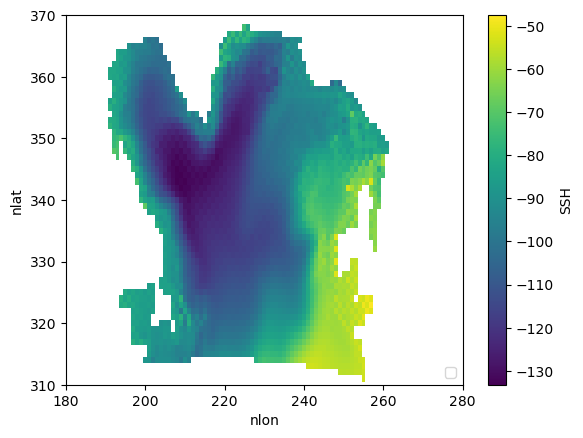

In [3]:
ds_plot.SSH.plot()

plt.xlim([180, 280])
plt.ylim([310, 370])

plt.legend(loc='lower right')

plt.show()

## Compute metric

In [4]:
def EOF(data, weights):

    # Apply spatial weighting
    weighted_data = data * weights
    shape = weighted_data.shape
    # Reshape your data into a 2D array (time, space)
    data_2d = weighted_data.reshape(shape[0], -1)
    # Calculate the mean per time step along the time axis (axis=0)
    mean_per_time_step = np.nanmean(data_2d, axis=1)
    # Find NaNs in your data
    nan_indices = np.isnan(data_2d)
    # Replace NaNs with the mean of the corresponding time step
    data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])
    # Calculate the mean along the time axis
    mean = np.mean(data_2d, axis=0)
    # Subtract the mean to center the data
    centered_data = data_2d - mean
    # Calculate the covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)
    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # EOF 1 time series 
    principal_components = eigenvectors[:, 0:1]
    # Project the data onto the principal components
    projected_data = centered_data.dot(principal_components)
    # Reconstruct the data from the principal component:
    reconstructed_data = (projected_data.dot(principal_components.T) + mean)
    reconstructed_data[nan_indices] = np.nan
    # Reshape the reconstructed data to the original shape
    original_shape_data = reconstructed_data.reshape(shape)
    original_shape_data = original_shape_data /weights
    # Find the minimum per time step, considering the entire 2D spatial field
    eof1 = np.nanmin(original_shape_data, axis=(1,2))

    # EOF 2 time series 
    principal_components = eigenvectors[:, 1:2]
    # Project the data onto the principal components
    projected_data = centered_data.dot(principal_components)
    # Reconstruct the data from the principal component:
    reconstructed_data = (projected_data.dot(principal_components.T) + mean)
    reconstructed_data[nan_indices] = np.nan
    # Reshape the reconstructed data to the original shape
    original_shape_data = reconstructed_data.reshape(shape)
    original_shape_data = original_shape_data /weights
    # Find the minimum per time step, considering the entire 2D spatial field
    eof2 = np.nanmin(original_shape_data, axis=(1,2))
    
    return eof1, eof2

In [5]:
ds = xr.open_dataset(files[0]).isel(time=slice(0,3)).where(mask3d == 1).roll(nlon=-100)
data = ds.SSH.values[:, 300:-10, 180:-50] 
weights = ds.TAREA.values[300:-10, 180:-50] 
eof1, eof2 = EOF(data, weights)

In [6]:
eof1

array([-138.37302111, -135.29714119, -134.88420015])